# Loan Default Prediction

This notebook walks through a full machine learning pipeline to predict loan defaults.
It includes data loading, preprocessing, class balancing using SMOTE-ENN, model training using different models, and performance visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from collections import Counter
import kagglehub

# Load dataset
dataset_path = kagglehub.dataset_download("nikhil1e9/Loan-default")
df = pd.read_csv(f"{dataset_path}/loan_default.csv")
df.drop(columns=['LoanID'], inplace=True)


## Initial Exploration
Let's look at data structure and check the balance between default and non-default cases.

Dataset shape: (255347, 17)
Data types:
 Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

Class distribution:
 Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64


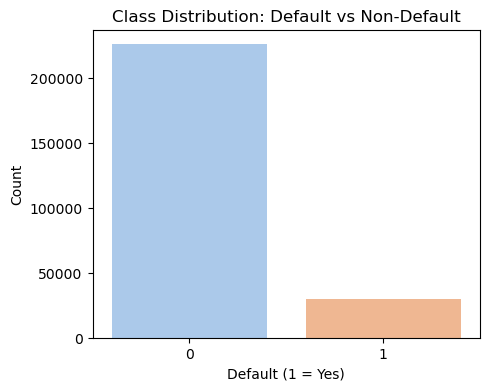

In [2]:
print("Dataset shape:", df.shape)
print("Data types:\n", df.dtypes)
print("\nClass distribution:\n", df['Default'].value_counts(normalize=True))

# Class distribution plot
plt.figure(figsize=(5, 4))
sns.countplot(x='Default', data=df, palette='pastel')
plt.title('Class Distribution: Default vs Non-Default')
plt.xlabel('Default (1 = Yes)')
plt.ylabel('Count')
plt.show()


## Encoding Categorical Variables

In [3]:
categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
                    'HasDependents', 'LoanPurpose', 'HasCoSigner']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))


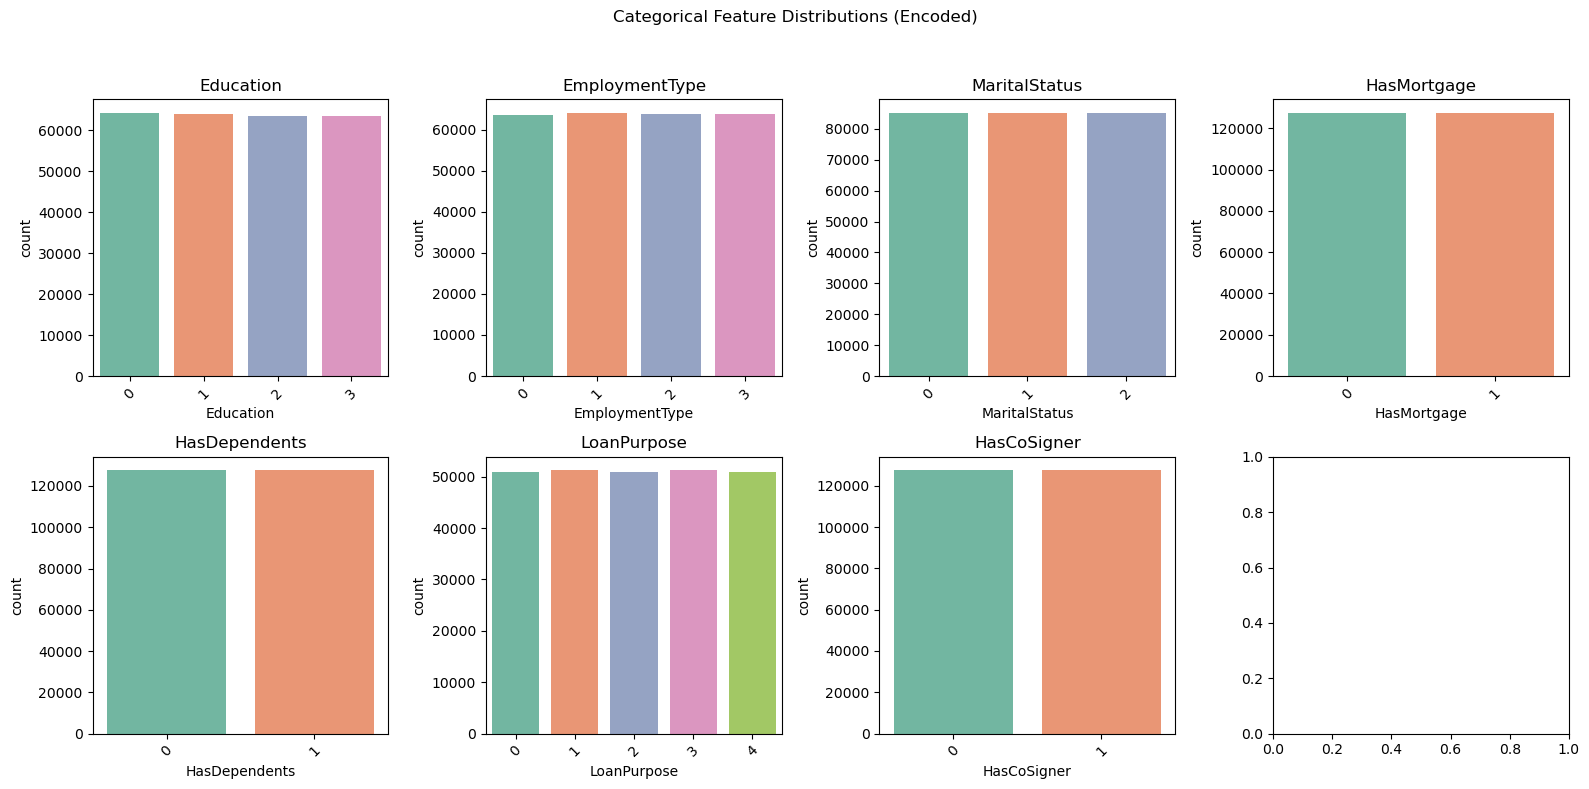

In [4]:
# Plot encoded categoricals
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)
plt.suptitle('Categorical Feature Distributions (Encoded)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Numerical Distributions and Correlation Heatmap

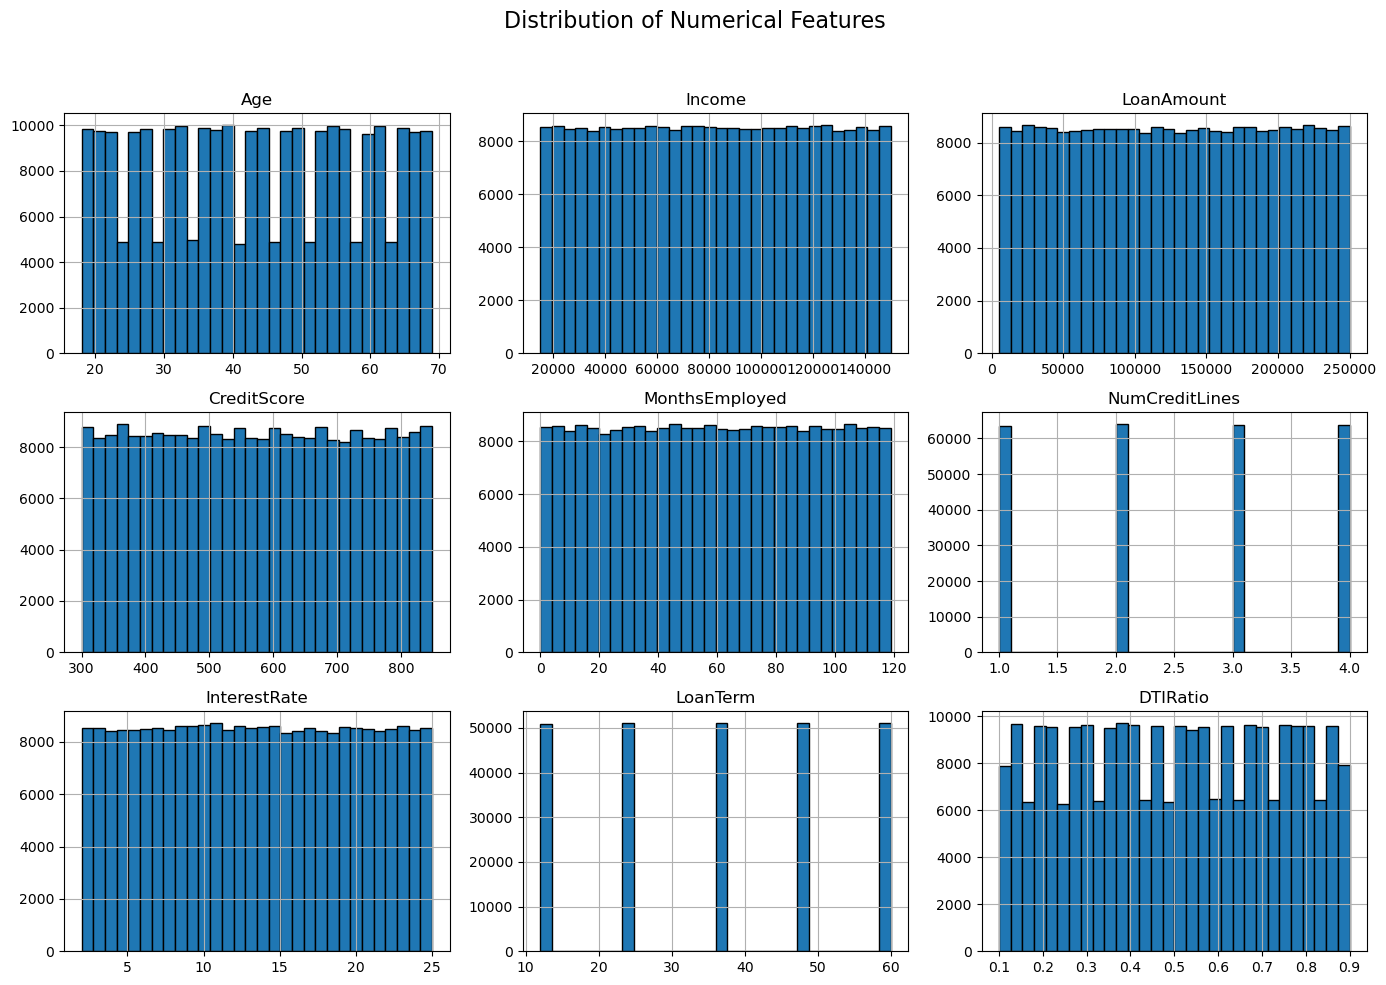

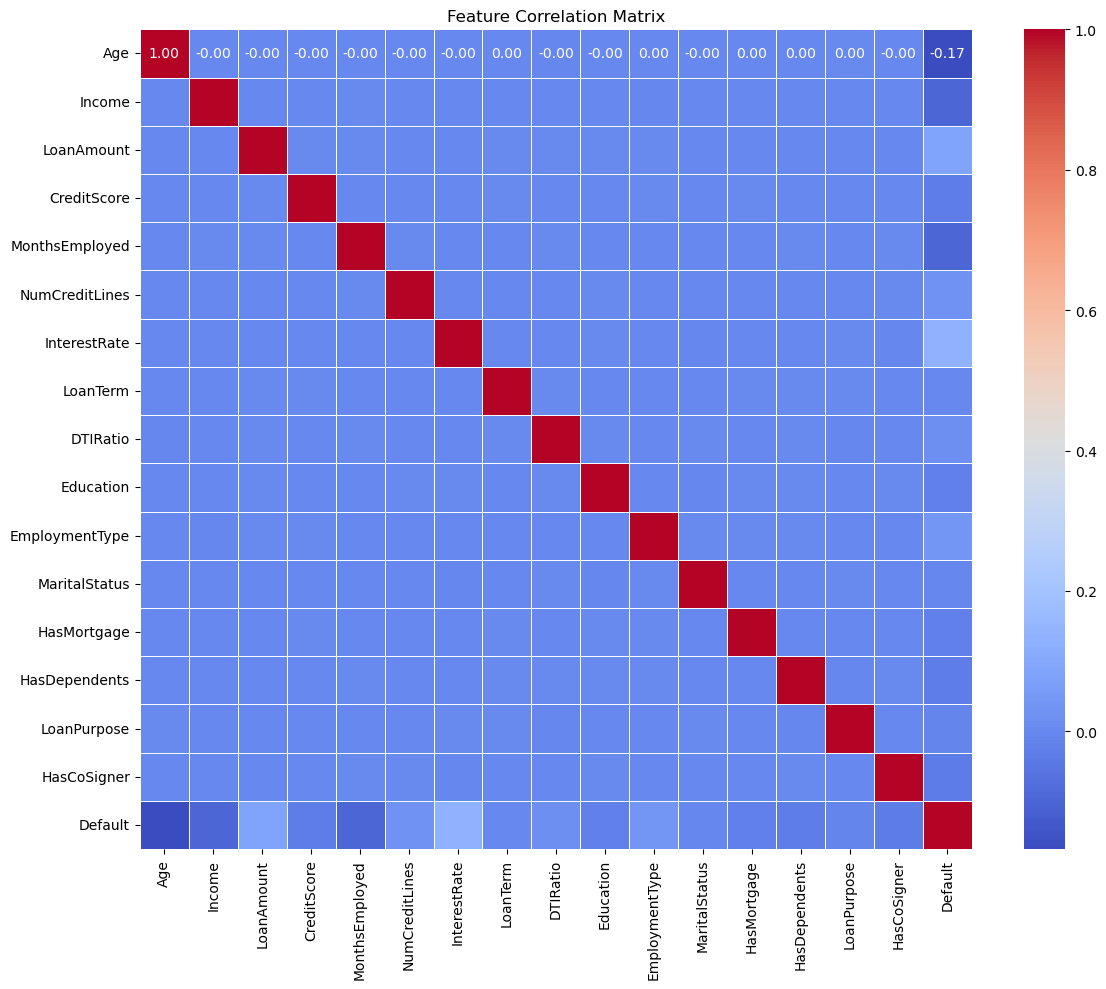

In [5]:
# Drop binned columns if present
df = df[[col for col in df.columns if not col.endswith('_binned') and 'Bin' not in col]]

# Histograms
numeric_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']
df[numeric_cols].hist(bins=30, figsize=(14, 10), edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


## Class Balancing with SMOTE-ENN

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


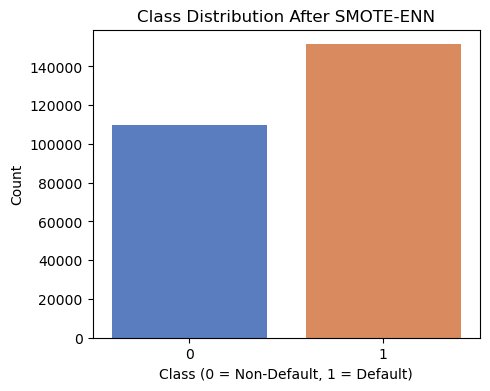

In [6]:
X = df.drop('Default', axis=1)
y = df['Default']

smenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smenn.fit_resample(X, y)

# Class distribution after resampling
resampled_counts = Counter(y_resampled)
plt.figure(figsize=(5, 4))
sns.barplot(x=list(resampled_counts.keys()), y=list(resampled_counts.values()), palette='muted')
plt.title("Class Distribution After SMOTE-ENN")
plt.xlabel("Class (0 = Non-Default, 1 = Default)")
plt.ylabel("Count")
plt.show()


## Train Random Forest and Evaluate Performance

In [7]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, random_state=42)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_probs = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

auc = roc_auc_score(y_test, y_probs)
print(f"\nAUC Score: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



AUC Score: 0.9076

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80     21803
           1       0.88      0.82      0.85     30377

    accuracy                           0.83     52180
   macro avg       0.82      0.83      0.82     52180
weighted avg       0.83      0.83      0.83     52180



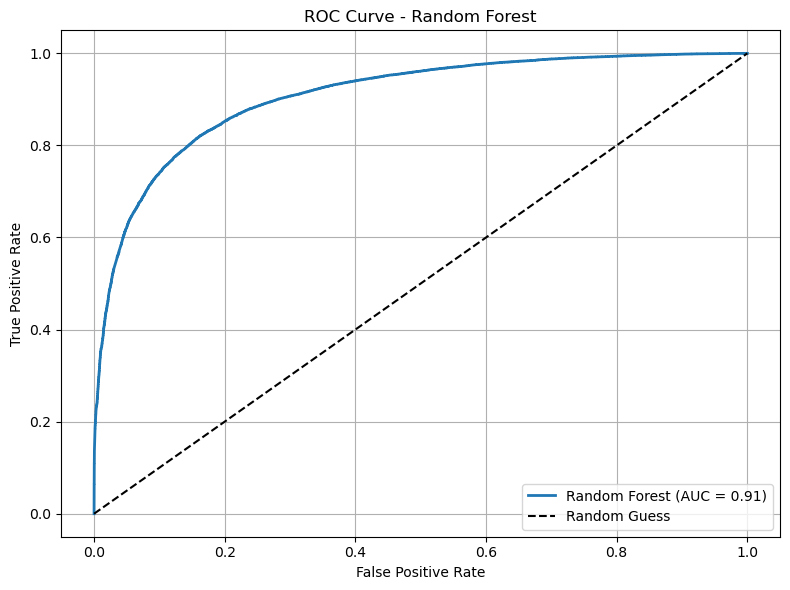

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance

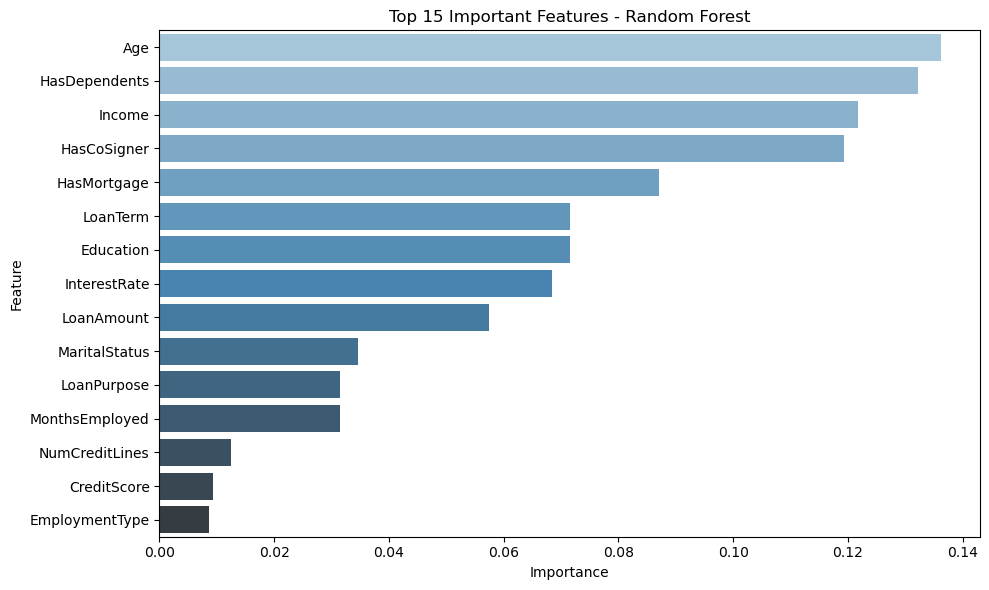

In [8]:
importances = rf.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(15), palette='Blues_d')
plt.title("Top 15 Important Features - Random Forest")
plt.tight_layout()
plt.show()


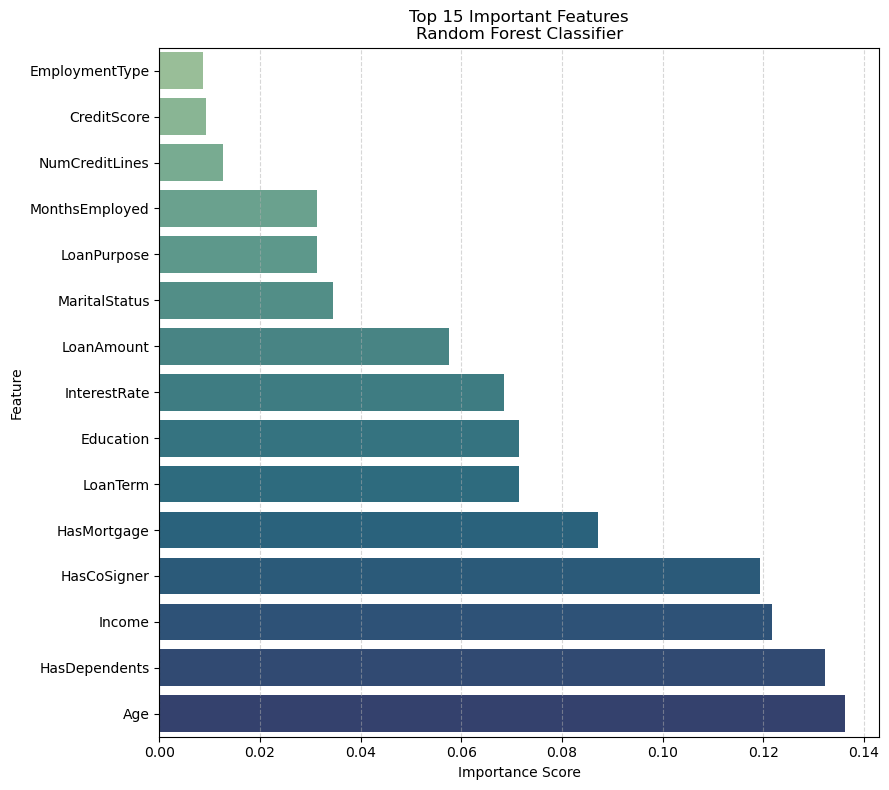

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feat_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=True)  # Ascending for vertical plot

# Plot - Vertical layout for poster
plt.figure(figsize=(9, 8))
sns.barplot(x='Importance', y='Feature', data=feat_df.tail(15), palette='crest')

plt.title("Top 15 Important Features\nRandom Forest Classifier", fontsize=12)
plt.xlabel("Importance Score", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
plt.savefig("random_forest_feature_importance.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


## Train Logistic Regression and Evaluate Performance

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
[[14648  7155]
 [ 5987 24390]]
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     21803
           1       0.77      0.80      0.79     30377

    accuracy                           0.75     52180
   macro avg       0.74      0.74      0.74     52180
weighted avg       0.75      0.75      0.75     52180

Logistic Regression AUC: 0.8165


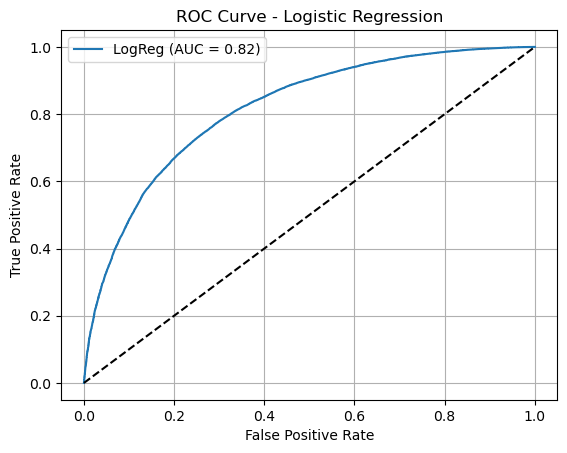

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict classes
y_pred_log = log_reg.predict(X_test)

# Predict probabilities for AUC
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# AUC Score
auc_log = roc_auc_score(y_test, y_proba_log)
print(f"Logistic Regression AUC: {auc_log:.4f}")

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
plt.figure()
plt.plot(fpr_log, tpr_log, label=f'LogReg (AUC = {auc_log:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()




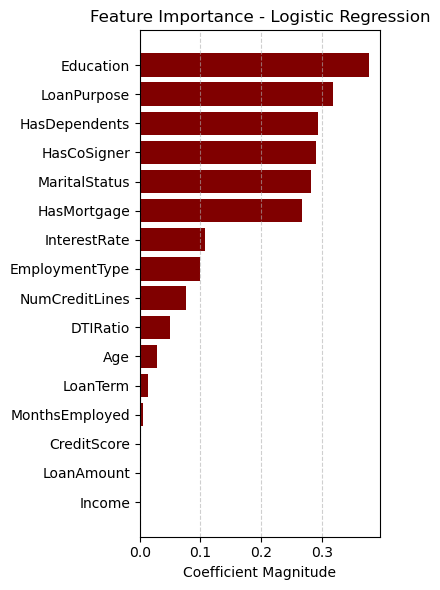

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance from logistic regression (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(log_reg.coef_[0])
}).sort_values(by='Importance', ascending=False)

# Plot feature importance vertically
plt.figure(figsize=(4, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='maroon')
plt.xlabel("Coefficient Magnitude")
plt.title("Feature Importance - Logistic Regression")
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

## Train XGBoost and Evaluate Performance

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:18:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results
[[19893  1910]
 [ 3575 26802]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     21803
           1       0.93      0.88      0.91     30377

    accuracy                           0.89     52180
   macro avg       0.89      0.90      0.89     52180
weighted avg       0.90      0.89      0.90     52180

XGBoost AUC: 0.9576


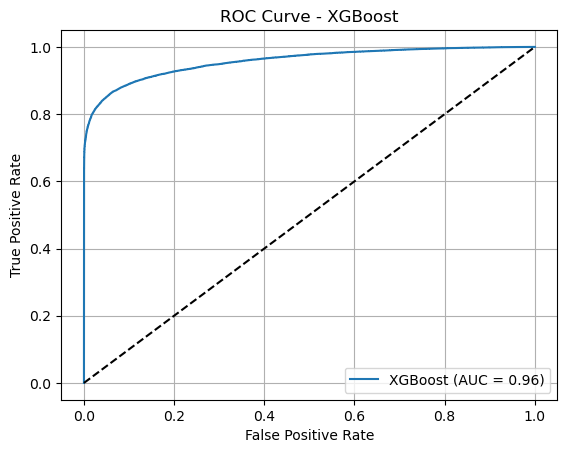

In [12]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print(f"XGBoost AUC: {auc_xgb:.4f}")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Train SVM - Linear Kernel and Evaluate Performance

/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual`

SVM (Linear Kernel via LinearSVC) Results
[[ 8116 13687]
 [ 2243 28134]]
              precision    recall  f1-score   support

           0       0.78      0.37      0.50     21803
           1       0.67      0.93      0.78     30377

    accuracy                           0.69     52180
   macro avg       0.73      0.65      0.64     52180
weighted avg       0.72      0.69      0.66     52180

SVM (Linear Kernel) AUC: 0.7664


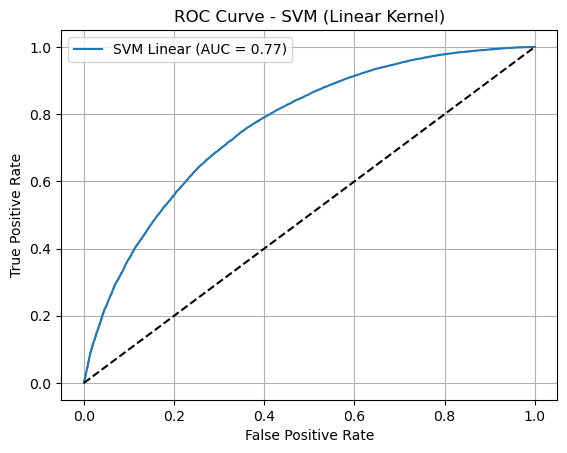

In [13]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Use LinearSVC with calibrated probabilities
base_svm = LinearSVC(max_iter=5000)
svm_linear = CalibratedClassifierCV(base_svm, cv=5)

# Fit the model
svm_linear.fit(X_train, y_train)

# Predict
y_pred_svm = svm_linear.predict(X_test)
y_proba_svm = svm_linear.predict_proba(X_test)[:, 1]

# Evaluation
print("SVM (Linear Kernel via LinearSVC) Results")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# AUC and ROC
auc_svm = roc_auc_score(y_test, y_proba_svm)
print(f"SVM (Linear Kernel) AUC: {auc_svm:.4f}")

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label=f'SVM Linear (AUC = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - SVM (Linear Kernel)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## Train CatBoost and Evaluate Performance

CatBoost Results
[[21001   802]
 [ 3217 27160]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     21803
           1       0.97      0.89      0.93     30377

    accuracy                           0.92     52180
   macro avg       0.92      0.93      0.92     52180
weighted avg       0.93      0.92      0.92     52180

CatBoost AUC: 0.9681


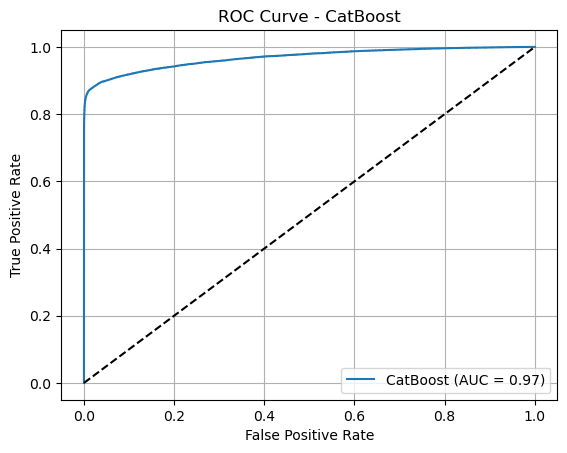

In [14]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize and fit CatBoost
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

# Predictions
y_pred_cat = cat_model.predict(X_test)
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluation
print("CatBoost Results")
print(confusion_matrix(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

# AUC Score
auc_cat = roc_auc_score(y_test, y_proba_cat)
print(f"CatBoost AUC: {auc_cat:.4f}")

# ROC Curve
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
plt.figure()
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_cat:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## Train MLP and Evaluate Performance

In [15]:
!pip install tensorflow

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5218/5218 ━━━━━━━━━━━━━━━━━━━━ 4s 610us/step - AUC: 0.8725 - loss: 0.4393 - val_AUC: 0.9013 - val_loss: 0.3933
Epoch 2/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 650us/step - AUC: 0.8954 - loss: 0.4030 - val_AUC: 0.9042 - val_loss: 0.3875
Epoch 3/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 624us/step - AUC: 0.8995 - loss: 0.3958 - val_AUC: 0.9058 - val_loss: 0.3836
Epoch 4/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 616us/step - AUC: 0.9000 - loss: 0.3945 - val_AUC: 0.9057 - val_loss: 0.3840
Epoch 5/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 634us/step - AUC: 0.9022 - loss: 0.3908 - val_AUC: 0.9074 - val_loss: 0.3802
Epoch 6/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 626us/step - AUC: 0.9036 - loss: 0.3884 - val_AUC: 0.9070 - val_loss: 0.3820
Epoch 7/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 612us/step - AUC: 0.9038 - loss: 0.3879 - val_AUC: 0.9085 - val_loss: 0.3799
Epoch 8/100
5218/5218 ━━━━━━━━━━━━━━━━━━━━ 3s 623us/step - AUC: 0.9046 - loss: 0.3862 - val_AUC: 0.9093 - val_loss: 0.3768
Epoch 9/100
5218/5218 ━━━━━━

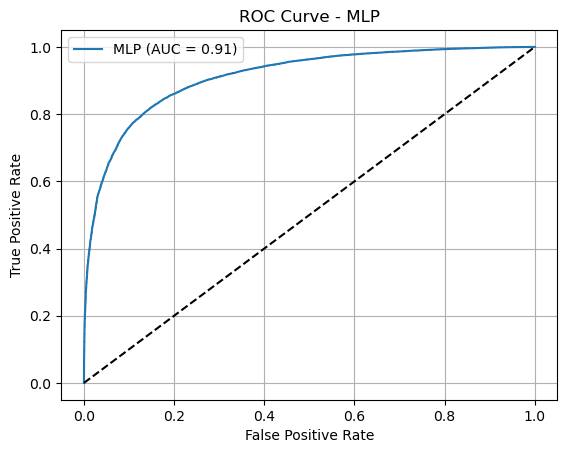

In [16]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 1. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Define the MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# 3. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Train the model
history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 5. Predict
y_proba_mlp = mlp_model.predict(X_test_scaled).ravel()
y_pred_mlp = (y_proba_mlp > 0.5).astype(int)

# 6. Evaluation
print("MLP Model Results")
print(confusion_matrix(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

auc_mlp = roc_auc_score(y_test, y_proba_mlp)
print(f"MLP Model AUC: {auc_mlp:.4f}")

# 7. ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
plt.figure()
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## Train Stacking Classifier and Evaluate Performance

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:32:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:35:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:35:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:35:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Stacking Classifier Results
[[20587  1216]
 [ 2933 27444]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     21803
           1       0.96      0.90      0.93     30377

    accuracy                           0.92     52180
   macro avg       0.92      0.92      0.92     52180
weighted avg       0.92      0.92      0.92     52180

Stacking Classifier AUC: 0.9689


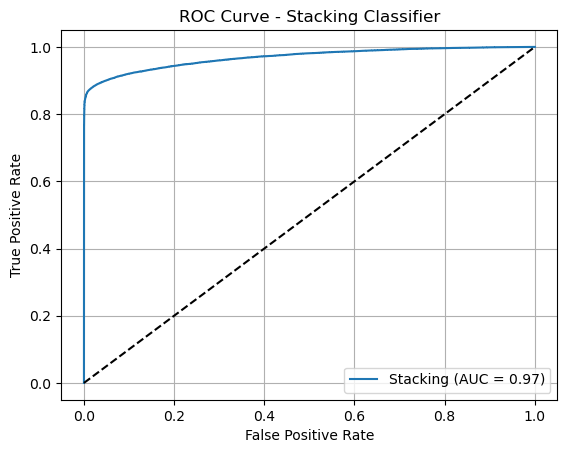

In [17]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('cat', CatBoostClassifier(verbose=0, random_state=42))
]

# Meta-learner: logistic regression (you can also try RandomForest or LightGBM)
final_estimator = LogisticRegression()

# Build the stacking classifier
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False  # If True, original features are added to meta model input
)

# Train the stacking classifier
stack_model.fit(X_train, y_train)

# Predictions
y_pred_stack = stack_model.predict(X_test)
y_proba_stack = stack_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Stacking Classifier Results")
print(confusion_matrix(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

auc_stack = roc_auc_score(y_test, y_proba_stack)
print(f"Stacking Classifier AUC: {auc_stack:.4f}")

# ROC Curve
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba_stack)
plt.figure()
plt.plot(fpr_stack, tpr_stack, label=f'Stacking (AUC = {auc_stack:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Stacking Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


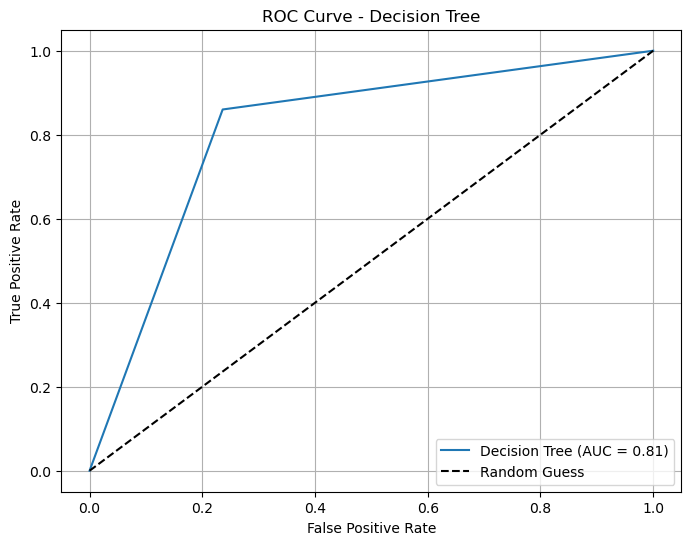

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# Assume data is already split into X_train, X_test, y_train, y_test
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict probabilities for ROC
y_pred_dt_proba = dt_model.predict_proba(X_test)[:, 1]

# ROC Curve and AUC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()


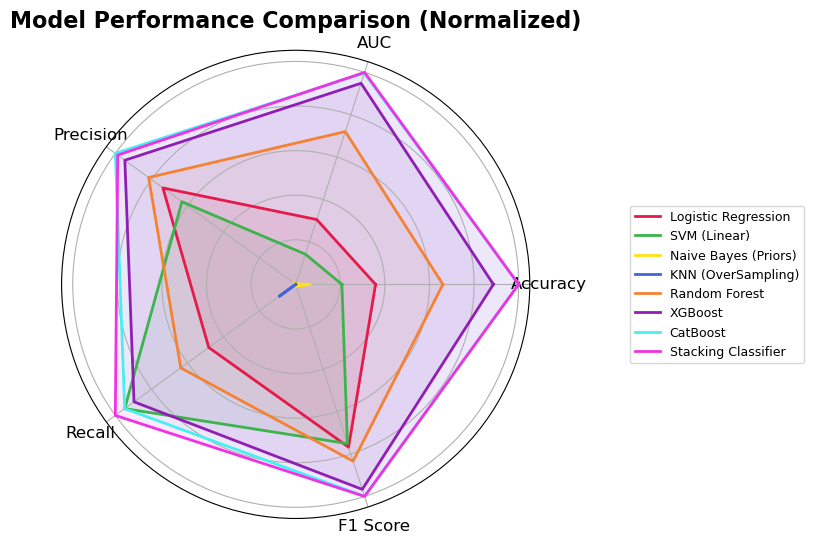

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names and metrics
models = [
    "Logistic Regression", "SVM (Linear)", "Naive Bayes (Priors)",
    "KNN (OverSampling)", "Random Forest", "XGBoost",
    "CatBoost", "Stacking Classifier"
]

metrics = ["Accuracy", "AUC", "Precision", "Recall", "F1 Score"]

# Original performance values
performance = {
    "Logistic Regression": [0.75, 0.8165, 0.77, 0.80, 0.79],
    "SVM (Linear)": [0.71, 0.7806, 0.69, 0.89, 0.78],
    "Naive Bayes (Priors)": [0.6719, 0.7499, 0.2183, 0.7070, 0.3335],
    "KNN (OverSampling)": [0.6551, 0.7494, 0.2119, 0.7243, 0.3278],
    "Random Forest": [0.83, 0.9076, 0.83, 0.83, 0.83],
    "XGBoost": [0.89, 0.9576, 0.93, 0.88, 0.91],
    "CatBoost": [0.92, 0.9681, 0.97, 0.89, 0.93],
    "Stacking Classifier": [0.92, 0.9689, 0.96, 0.90, 0.93],
}

# Normalize metrics
metric_array = np.array([performance[model] for model in models])
min_vals = metric_array.min(axis=0)
max_vals = metric_array.max(axis=0)
normalized = (metric_array - min_vals) / (max_vals - min_vals)

# Radar chart setup
labels = np.array(metrics)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Very distinct colors
distinct_colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8",
    "#f58231", "#911eb4", "#46f0f0", "#f032e6"
]

# Plotting
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for idx, model in enumerate(models):
    values = normalized[idx].tolist()
    values += values[:1]
    ax.plot(angles, values, color=distinct_colors[idx], linewidth=2, label=model)
    ax.fill(angles, values, color=distinct_colors[idx], alpha=0.1)

ax.set_title("Model Performance Comparison (Normalized)", size=16, weight='bold')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])
ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=9)
plt.tight_layout()
plt.show()



In [20]:
!pip install qrcode

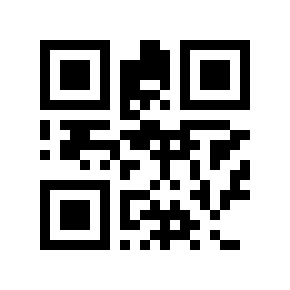

In [21]:
import qrcode

# Replace this URL with your GitHub/project link
url = "xyz"

# Generate QR code
qr = qrcode.make(url)

# Save it as an image
qr.save("qr_code.png")

# If using Jupyter, display it directly
from IPython.display import Image
Image("qr_code.png")


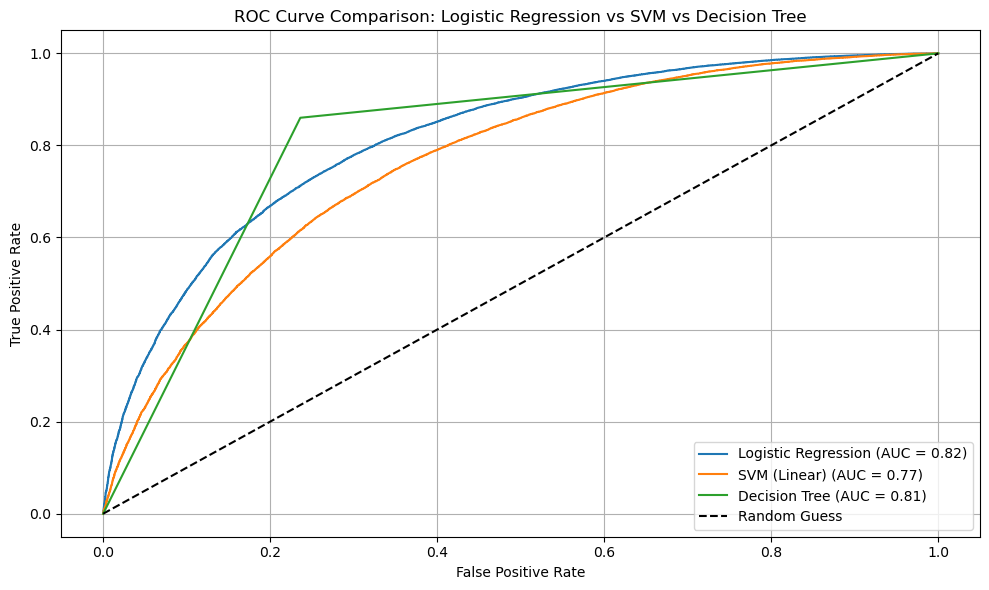

In [22]:
import matplotlib.pyplot as plt

# Plot all ROC curves
plt.figure(figsize=(10, 6))

# Logistic Regression
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})')

# SVM
plt.plot(fpr_svm, tpr_svm, label=f'SVM (Linear) (AUC = {auc_svm:.2f})')

# Decision Tree
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Random Guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Labels and legend
plt.title('ROC Curve Comparison: Logistic Regression vs SVM vs Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


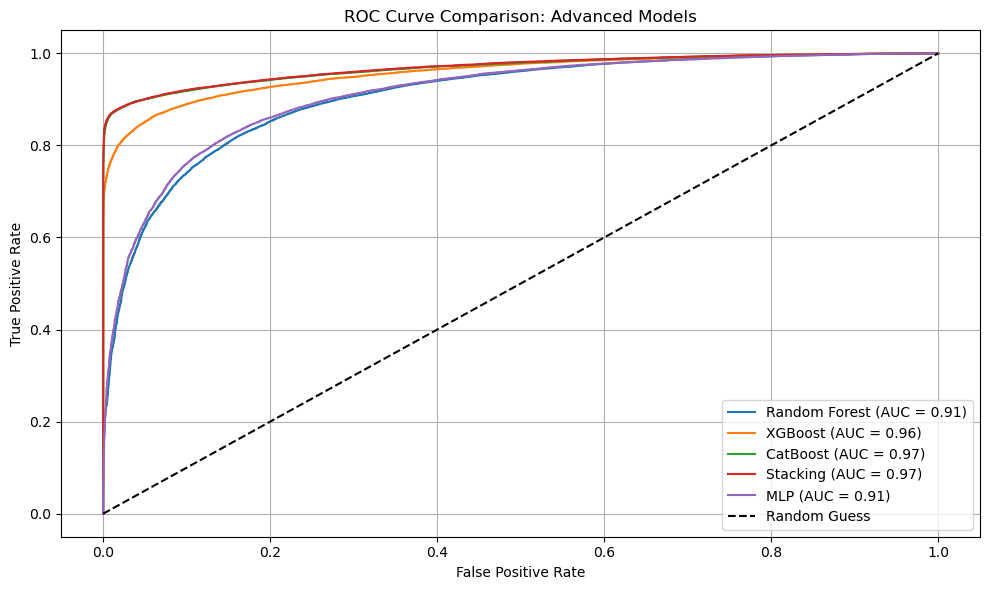

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_cat:.2f})')
plt.plot(fpr_stack, tpr_stack, label=f'Stacking (AUC = {auc_stack:.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Comparison: Advanced Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



In [28]:
import pandas as pd

# Data
data = {
    'Model': ['Random Forest', 'XGBoost', 'CatBoost', 'MLP', 'Stacking'],
    'Accuracy': [0.83, 0.89, 0.92, 0.84, 0.92],
    'AUC': [0.9076, 0.9576, 0.9681, 0.9153, 0.9689],
    'Precision': [0.83, 0.93, 0.97, 0.88, 0.96],
    'Recall': [0.83, 0.88, 0.89, 0.84, 0.90],
    'F1-Score': [0.83, 0.91, 0.93, 0.86, 0.93]
}

df = pd.DataFrame(data)

# Function to highlight max values in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: orange' if v else '' for v in is_max]

# Apply the styling
styled_df = df.style.apply(highlight_max, subset=['Accuracy', 'AUC', 'Precision', 'Recall', 'F1-Score']) \
                    .set_properties(**{'text-align': 'center'}) \
                    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
                    .format(precision=4)

# Display in notebook
styled_df



,Model,Accuracy,AUC,Precision,Recall,F1-Score
0,Random Forest,0.8300,0.9076,0.8300,0.8300,0.8300
1,XGBoost,0.8900,0.9576,0.9300,0.8800,0.9100
2,CatBoost,0.9200,0.9681,0.9700,0.8900,0.9300
3,MLP,0.8400,0.9153,0.8800,0.8400,0.8600
4,Stacking,0.9200,0.9689,0.9600,0.9000,0.9300


In [33]:
# Reuse this function if not already in your notebook
from sklearn.metrics import precision_recall_curve
import numpy as np
import pandas as pd

def evaluate_tradeoff(y_true, y_scores, fixed='precision', target_value=0.99):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    if fixed == 'precision':
        idx = np.where(precision >= target_value)[0]
        if len(idx) == 0:
            return None, None, None
        best_recall = recall[idx[0]]
        return best_recall, precision[idx[0]], thresholds[idx[0]]
    
    elif fixed == 'recall':
        idx = np.where(recall >= target_value)[0]
        if len(idx) == 0:
            return None, None, None
        best_precision = precision[idx[-1]]
        return recall[idx[-1]], best_precision, thresholds[idx[-1]]
    
    else:
        return None, None, None


# Collect all model probabilities
models_info = {
    "Random Forest": y_probs,
    "XGBoost": y_proba_xgb,
    "CatBoost": y_proba_cat,
    "MLP": y_proba_mlp,
    "Stacking": y_proba_stack
}

# Evaluate both strategies
results = []

for model_name, y_proba in models_info.items():
    # Customer-First: Fix Precision @ 0.99
    recall_cp, prec_cp, th_cp = evaluate_tradeoff(y_test, y_proba, fixed='precision', target_value=0.99)
    
    # Risk-First: Fix Recall @ 0.90
    recall_rf, prec_rf, th_rf = evaluate_tradeoff(y_test, y_proba, fixed='recall', target_value=0.90)
    
    results.append({
        "Model": model_name,
        "Recall @ P≥0.99 (😊)": round(recall_cp, 4) if recall_cp is not None else "—",
        "Precision @ R≥0.90 (⚠️)": round(prec_rf, 4) if prec_rf is not None else "—",
        "Threshold (😊)": round(th_cp, 4) if th_cp is not None else "—",
        "Threshold (⚠️)": round(th_rf, 4) if th_rf is not None else "—"
    })

# Display results
results_df = pd.DataFrame(results)
results_df.set_index("Model", inplace=True)
results_df


,Recall @ P≥0.99 (😊),Precision @ R≥0.90 (⚠️),Threshold (😊),Threshold (⚠️)
Model,,,,
Random Forest,0.2270,0.8168,0.9093,0.3805
XGBoost,0.7718,0.9120,0.8219,0.4290
CatBoost,0.8718,0.9620,0.6578,0.4580
MLP,0.2399,0.8232,0.9753,0.3905
Stacking,0.8727,0.9622,0.8551,0.5361


/var/folders/2g/bs_2yyg13ygccpxhqbgv0ptm0000gn/T/ipykernel_80905/4290814954.py:33: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/2g/bs_2yyg13ygccpxhqbgv0ptm0000gn/T/ipykernel_80905/4290814954.py:33: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/var/folders/2g/bs_2yyg13ygccpxhqbgv0ptm0000gn/T/ipykernel_80905/4290814954.py:33: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128522 (\N{SMILING FACE WITH SMILING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from current font.
  fig.canvas.print_figure

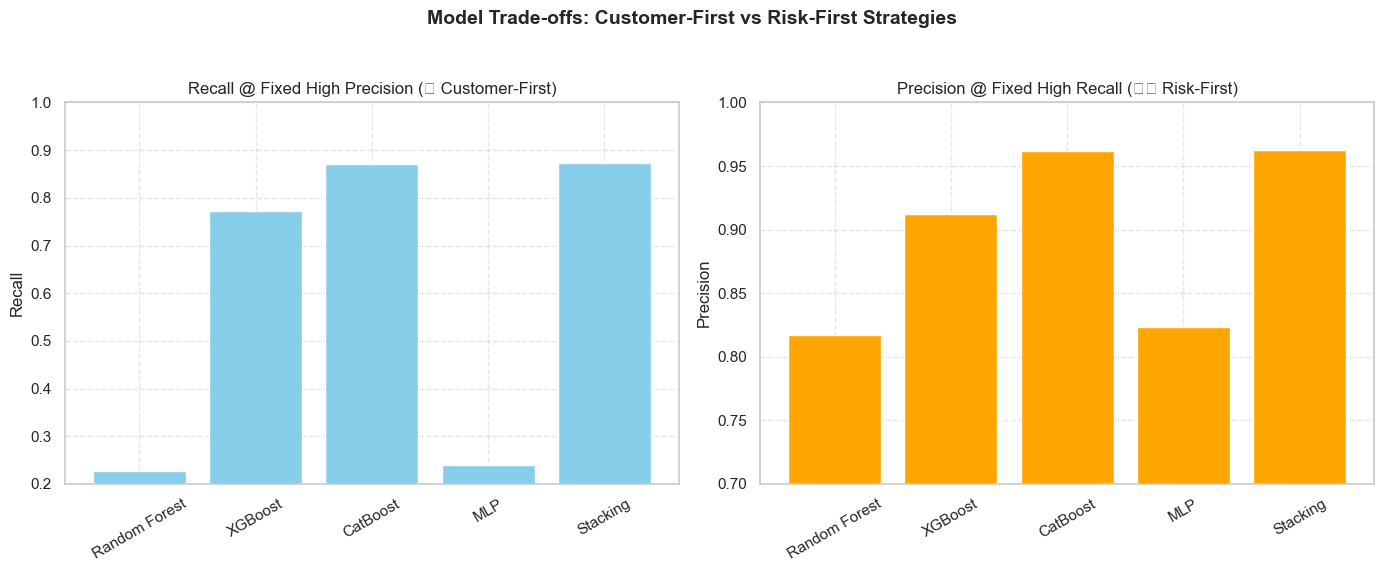

In [34]:
import matplotlib.pyplot as plt

# === Data based on threshold-tuned results ===
models = ["Random Forest", "XGBoost", "CatBoost", "MLP", "Stacking"]

# 1. Recall when Precision is fixed at 99% (Customer-First strategy)
recall_at_high_precision = [0.2270, 0.7718, 0.8718, 0.2399, 0.8727]

# 2. Precision when Recall is fixed at 90% (Risk-First strategy)
precision_at_high_recall = [0.8168, 0.9120, 0.9620, 0.8232, 0.9622]

# === Plotting side-by-side bar charts ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: Recall at fixed high precision
axs[0].bar(models, recall_at_high_precision, color='skyblue')
axs[0].set_ylim(0.2, 1.0)
axs[0].set_title('Recall @ Fixed High Precision (😊 Customer-First)', fontsize=12)
axs[0].set_ylabel('Recall')
axs[0].tick_params(axis='x', rotation=30)
axs[0].grid(True, linestyle='--', alpha=0.5)

# Right: Precision at fixed high recall
axs[1].bar(models, precision_at_high_recall, color='orange')
axs[1].set_ylim(0.7, 1.0)
axs[1].set_title('Precision @ Fixed High Recall (⚠️ Risk-First)', fontsize=12)
axs[1].set_ylabel('Precision')
axs[1].tick_params(axis='x', rotation=30)
axs[1].grid(True, linestyle='--', alpha=0.5)

# Overall Title
plt.suptitle('Model Trade-offs: Customer-First vs Risk-First Strategies', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
